In [1]:
import os
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import glob
from tqdm import tqdm
from pathlib import Path
import json
import random


In [2]:
dataset_path = '/datasets/ricordi'

In [3]:
def data_json(dataset_path):
    dataset = []
    # iterate through all folders in the directory
    for folder in glob.glob(dataset_path + '/*'):
        for files in glob.glob(folder + '/*'):
            # check if the file is either a folder or a json file
            if os.path.isdir(files):
                for data_path in glob.glob(files + '/*'):
                    dataset.append(glob.glob(data_path + '/*.json'))
            elif files.endswith('.json'):
                dataset.append(files)
    dataset = list(flatten(dataset))
    print("Total json files:", len(dataset))
    return dataset

In [4]:
def sort_by_key(data,key):
    dataset = []
    for i in data:
        f = open(i)
        json_data = json.load(f)
        if key in json_data:
            dataset.append(i)
        else:
            continue
    print("Json with annotazione1 present:",len(dataset))
    return dataset

In [5]:
dmerge_classes = [[2, 15], [7, 9]]
classes_relevant = [5,6,7,8,9,10,11,12,14,16]
classes_irrelevant = [0,1,2,3,4,15,17]
classes = classes_relevant + classes_irrelevant

# Define the class names in the same order as the classes list
class_names_relevant = [
    "Pause (full or almost)",
    "Single note (with at least the head)",
    "Multiple Notes (with at least the head)",
    "Single chord (with at least heads)",
    "Multiple chords (with at least heads)",
    "Accidental(s) (whole or nearly so)",
    "Key(s) (whole(s) or nearly)",
    "Embellishment(s) (whole(s) or nearly)",
    "More categories (with at least one musical sign)",
    "Other (with at least one musical sign)"
]

class_names_irrelevant = [
    "Page border",
    "Erasure",
    "Blurr",
    "Printed Text",
    "Manuscript Text",
    "More categories (no musical signs)",
    "Other (without musical markings)"
]

# Combine the relevant and irrelevant class names
class_names = class_names_relevant + class_names_irrelevant

In [6]:
json_list = data_json(dataset_path)
sorted_list_by_key = sort_by_key(json_list, "annotazione1")

Total json files: 469590


Json with annotazione1 present: 196639


In [7]:
def plot_distribution_by_class(sorted_list_by_key, classes, key):
    count = {i: 0 for i in classes}
    
    for i in sorted_list_by_key:
        with open(i) as f:
            json_data = json.load(f)
            class_index = json_data[key]
            count[class_index] += 1
    
    print(count)

    # reorder classes, relevant first
    count = [count[i] for i in classes_relevant] + [count[i] for i in classes_irrelevant]
    labels = ["Relevant"] + [None] * (len(classes_relevant) - 1) + ["Irrelevant"] + [None] * (len(classes_irrelevant) - 1)
    colors = ["tab:red" for _ in classes_relevant] + ["tab:blue" for _ in classes_irrelevant]
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.rcParams.update({'font.size': 8})
    plt.bar(x, count, label=labels, color=colors)
    plt.xticks(x, class_names, rotation=45, ha='right')  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.legend()
    plt.yscale('log')
    plt.ylim(300, 130000)
    plt.show()

    return count

{5: 316, 6: 2998, 7: 5621, 8: 975, 9: 818, 10: 2206, 11: 3370, 12: 779, 14: 9039, 16: 1173, 0: 118966, 1: 10370, 2: 13052, 3: 4246, 4: 12501, 15: 1443, 17: 8766}


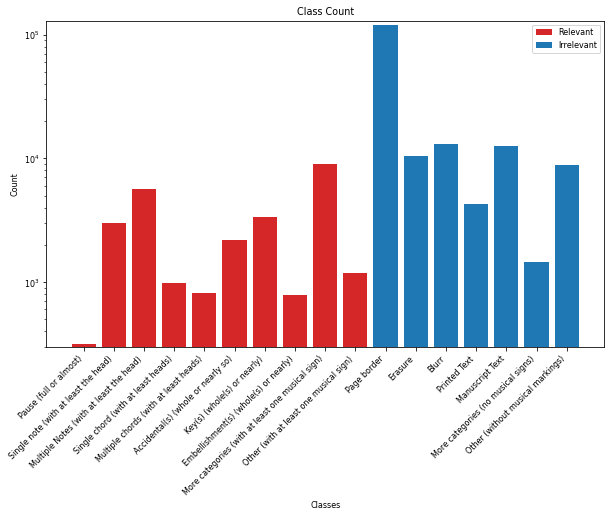

In [8]:
count = plot_distribution_by_class(sorted_list_by_key,classes, "annotazione1")

In [9]:
# Merge classes that have cardinality < 0.5 of median cardinality
merged = []
m = np.median(count)
print("Median is", m)
print("Mean is", np.mean(count))
print("Min is", np.min(count))

# note, we force classes 9 and 7 and classes 15 and 2 to look like if they the same number of samples 
# (the sum of the two) so that they are appended to `merged` together
count_ = np.copy(count)
count_[classes.index(9)] += count_[classes.index(7)]
count_[classes.index(15)] += count_[classes.index(2)]
count_[classes.index(7)] = count_[classes.index(9)]
count_[classes.index(2)] = count_[classes.index(15)]

for i, c in enumerate(count_):
    if c < 0.75 * m:
        merged.append(classes[i])

print("Merging classes:", [class_names[classes.index(i)] for i in merged])
print("Total of `Remaining` class: ", sum(count_[classes.index(c)] for c in merged if c not in [15, 9]))

Median is 3370.0
Mean is 11567.0
Min is 316
Merging classes: ['Pause (full or almost)', 'Single chord (with at least heads)', 'Accidental(s) (whole or nearly so)', 'Embellishment(s) (whole(s) or nearly)', 'Other (with at least one musical sign)']
Total of `Remaining` class:  5449


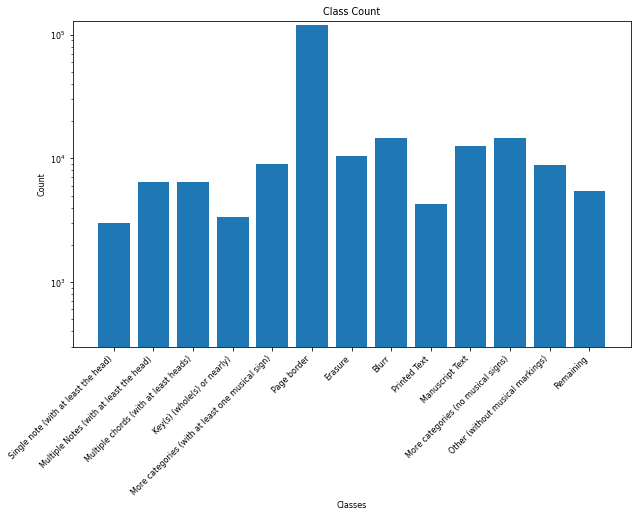

Median now is 8766.0
Mean now is 16736.384615384617
Min now is 2998
Cardinalities: [('Single note (with at least the head)', 2998), ('Multiple Notes (with at least the head)', 6439), ('Multiple chords (with at least heads)', 6439), ('Key(s) (whole(s) or nearly)', 3370), ('More categories (with at least one musical sign)', 9039), ('Page border', 118966), ('Erasure', 10370), ('Blurr', 14495), ('Printed Text', 4246), ('Manuscript Text', 12501), ('More categories (no musical signs)', 14495), ('Other (without musical markings)', 8766), ('Remaining', 5449)]


In [10]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

count__ = [count_[i] for i in range(len(class_names)) if classes[i] not in merged]
count__.append(sum([count_[classes.index(c)] for c in merged if c not in [15, 9]]))
class_names_ = [class_names[i] for i in range(len(class_names)) if classes[i] not in merged]
class_names_.append("Remaining")

x = np.arange(len(class_names_))  # Generate an array of class indices
plt.rcParams.update({'font.size': 8})
plt.bar(x, count__) # , label=labels, color=colors)
plt.xticks(x, class_names_, rotation=45, ha='right')  # Set custom x-axis tick positions and labels
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Count")
plt.yscale('log')
plt.ylim(300, 130000)
plt.show()
print("Median now is", np.median(count__))
print("Mean now is", np.mean(count__))
print("Min now is", np.min(count__))
print("Cardinalities:", list(zip(class_names_, count__)))

In [11]:
from pathlib import Path

source_dataset_path = Path('./data/source/')
binary_dataset_path = Path('./data/binary_dataset')
relevant_path = binary_dataset_path / 'data' / 'relevant'
irrelevant_path = binary_dataset_path / 'data' / 'irrelevant'
source_dataset_path.mkdir(exist_ok=True, parents=True)
relevant_path.mkdir(exist_ok=True, parents=True)
irrelevant_path.mkdir(exist_ok=True, parents=True)
multiclass_dataset_path = Path('./data/multiclass_dataset') / 'data'

In [12]:
from shutil import copyfile

# copy all relevant images to both datasets
for json_file in tqdm(Path(dataset_path).glob("**/*.json")):
    with open(json_file, 'r') as f:
        data = json.load(f)
        if "annotazione1" in data:
            label = int(data["annotazione1"])
            png_path = Path(data["path"][18:])
            # compute the name of the physical copy
            copied_path = source_dataset_path / png_path
            # copy the file
            if not copied_path.exists():
                copied_path.parent.mkdir(exist_ok=True, parents=True)
                copyfile(dataset_path / png_path, copied_path)
            
            # symlink into the binary dataset
            if label in classes_irrelevant:
                binary_path = irrelevant_path / png_path.name
            elif label in classes_relevant:
                binary_path = relevant_path / png_path.name
            else:
                print("Unknown label!")
            target = os.path.relpath(copied_path, start=binary_path.parent)
            if not binary_path.exists():
                binary_path.symlink_to(target)
            
            # symlink to the multiclass dataset
            # N.B. handle merged classes
            if label in merged:
                class_name = "Remaining"
            elif label in [9, 7]:
                class_name = "Multiple notes or chords"
            elif label in [15, 2]:
                class_name = "Blurr or multiple categories (no music signs)"
            else:
                class_name = class_names[classes.index(label)]
            class_path = multiclass_dataset_path / class_name
            class_path.mkdir(exist_ok=True, parents=True)
            multiclass_name = (class_path / png_path.name)
            # note relative_to doesn't work for an issue in python 3.9 https://bugs.python.org/issue40358
            target = os.path.relpath(copied_path, start=multiclass_name.parent)
            if not multiclass_name.exists():
                multiclass_name.symlink_to(target)

0it [00:00, ?it/s]

1157it [00:00, 11565.57it/s]

2314it [00:00, 10811.24it/s]

3625it [00:00, 11818.66it/s]

5084it [00:00, 12886.14it/s]

6379it [00:00, 12891.13it/s]

7715it [00:00, 13046.16it/s]

9023it [00:00, 12954.21it/s]

10321it [00:00, 12944.35it/s]

11623it [00:00, 12967.39it/s]

12924it [00:01, 12978.99it/s]

14266it [00:01, 13112.77it/s]

15583it [00:01, 13125.07it/s]

16956it [00:01, 13306.48it/s]

18287it [00:01, 13097.13it/s]

19598it [00:01, 12456.63it/s]

20880it [00:01, 12560.37it/s]

22162it [00:01, 12635.20it/s]

23430it [00:01, 12636.97it/s]

24713it [00:01, 12693.54it/s]

26019it [00:02, 12801.39it/s]

27308it [00:02, 12827.26it/s]

28592it [00:02, 9983.62it/s] 

29688it [00:02, 10210.15it/s]

30990it [00:02, 10946.27it/s]

32266it [00:02, 11439.82it/s]

33571it [00:02, 11886.01it/s]

34797it [00:02, 11362.27it/s]

35963it [00:02, 11274.48it/s]

37262it [00:03, 11756.52it/s]

38598it [00:03, 12211.73it/s]

39834it [00:03, 12096.55it/s]

41162it [00:03, 12438.54it/s]

42414it [00:03, 11856.48it/s]

43644it [00:03, 11980.35it/s]

44944it [00:03, 12274.96it/s]

46179it [00:03, 11899.98it/s]

47376it [00:03, 10793.38it/s]

48749it [00:04, 11589.50it/s]

50011it [00:04, 11874.97it/s]

51375it [00:04, 12377.77it/s]

52629it [00:04, 11758.37it/s]

53948it [00:04, 12157.66it/s]

55178it [00:04, 11604.16it/s]

56539it [00:04, 12165.44it/s]

57769it [00:04, 11658.97it/s]

58948it [00:04, 11668.99it/s]

60194it [00:04, 11891.37it/s]

61391it [00:05, 11572.43it/s]

62670it [00:05, 11920.45it/s]

64043it [00:05, 12445.22it/s]

65312it [00:05, 12516.61it/s]

66610it [00:05, 12651.05it/s]

67879it [00:05, 12642.20it/s]

69305it [00:05, 13114.98it/s]

70619it [00:05, 12983.15it/s]

71919it [00:05, 12973.35it/s]

73335it [00:06, 13323.53it/s]

74669it [00:06, 9272.75it/s] 

75765it [00:06, 9246.67it/s]

76808it [00:06, 9373.56it/s]

77987it [00:06, 9979.26it/s]

79057it [00:06, 9625.07it/s]

80441it [00:06, 10731.26it/s]

81693it [00:06, 11214.14it/s]

83063it [00:06, 11911.07it/s]

84332it [00:07, 12132.39it/s]

85696it [00:07, 12569.26it/s]

87015it [00:07, 12749.85it/s]

88304it [00:07, 11768.74it/s]

89583it [00:07, 12049.87it/s]

90923it [00:07, 12430.97it/s]

92210it [00:07, 12554.98it/s]

93566it [00:07, 12846.23it/s]

94860it [00:07, 12014.48it/s]

96198it [00:08, 12396.12it/s]

97452it [00:08, 12009.55it/s]

98664it [00:08, 11444.98it/s]

99820it [00:08, 11326.12it/s]

101094it [00:08, 11718.53it/s]

102274it [00:08, 11101.43it/s]

103395it [00:08, 10910.98it/s]

104513it [00:08, 10986.42it/s]

105923it [00:08, 11878.08it/s]

107177it [00:09, 12067.15it/s]

108480it [00:09, 12348.13it/s]

109760it [00:09, 12478.65it/s]

111053it [00:09, 12611.20it/s]

112317it [00:09, 11758.93it/s]

113507it [00:09, 11429.09it/s]

114660it [00:09, 11251.63it/s]

115792it [00:09, 11063.55it/s]

116997it [00:09, 11343.42it/s]

118361it [00:09, 12001.28it/s]

119567it [00:10, 11652.64it/s]

120738it [00:10, 8421.49it/s] 

122056it [00:10, 9509.81it/s]

123310it [00:10, 10256.40it/s]

124566it [00:10, 10851.48it/s]

125969it [00:10, 11712.15it/s]

127206it [00:10, 11258.00it/s]

128461it [00:10, 11608.25it/s]

129756it [00:11, 11981.48it/s]

130983it [00:11, 11734.68it/s]

132197it [00:11, 11848.66it/s]

133397it [00:11, 11739.45it/s]

134671it [00:11, 12026.94it/s]

136028it [00:11, 12477.66it/s]

137303it [00:11, 12557.40it/s]

138644it [00:11, 12808.61it/s]

140070it [00:11, 13240.07it/s]

141398it [00:11, 12245.23it/s]

142640it [00:12, 12057.51it/s]

143858it [00:12, 11100.98it/s]

145161it [00:12, 11622.91it/s]

146532it [00:12, 12201.62it/s]

147812it [00:12, 12369.13it/s]

149292it [00:12, 13071.01it/s]

150612it [00:12, 12984.73it/s]

151923it [00:12, 13018.80it/s]

153231it [00:12, 12971.55it/s]

154533it [00:13, 12115.26it/s]

155780it [00:13, 12212.76it/s]

157064it [00:13, 12391.00it/s]

158311it [00:13, 11425.69it/s]

159473it [00:13, 11084.32it/s]

160601it [00:13, 11136.32it/s]

162022it [00:13, 12002.56it/s]

163292it [00:13, 12202.97it/s]

164550it [00:13, 12311.17it/s]

165788it [00:13, 11876.24it/s]

166984it [00:14, 10715.87it/s]

168240it [00:14, 11211.49it/s]

169497it [00:14, 11588.90it/s]

170741it [00:14, 11829.78it/s]

171939it [00:14, 8190.73it/s] 

172948it [00:14, 8611.04it/s]

174235it [00:14, 9633.74it/s]

175313it [00:14, 9838.38it/s]

176380it [00:15, 10057.58it/s]

177512it [00:15, 10403.21it/s]

178619it [00:15, 10590.75it/s]

179869it [00:15, 11138.47it/s]

181232it [00:15, 11860.96it/s]

182636it [00:15, 12496.35it/s]

183916it [00:15, 12584.98it/s]

185226it [00:15, 12737.54it/s]

186610it [00:15, 13062.26it/s]

187922it [00:15, 13036.59it/s]

189234it [00:16, 13049.32it/s]

190662it [00:16, 13416.02it/s]

192006it [00:16, 13119.14it/s]

193321it [00:16, 12991.75it/s]

194756it [00:16, 13388.22it/s]

196098it [00:16, 12484.41it/s]

197360it [00:16, 11971.84it/s]

198689it [00:16, 12335.73it/s]

199996it [00:16, 12544.10it/s]

201394it [00:17, 12957.38it/s]

202698it [00:17, 12797.93it/s]

203984it [00:17, 12415.35it/s]

205232it [00:17, 11253.73it/s]

206380it [00:17, 11105.22it/s]

207506it [00:17, 11020.41it/s]

208871it [00:17, 11748.30it/s]

210150it [00:17, 12043.93it/s]

211365it [00:17, 11750.11it/s]

212619it [00:18, 11975.25it/s]

214060it [00:18, 12679.23it/s]

215365it [00:18, 12785.45it/s]

216649it [00:18, 12743.33it/s]

218020it [00:18, 13028.65it/s]

219326it [00:18, 11763.54it/s]

220726it [00:18, 12376.65it/s]

221986it [00:18, 12425.71it/s]

223249it [00:18, 12482.73it/s]

224602it [00:18, 12784.18it/s]

225890it [00:19, 12108.12it/s]

227114it [00:19, 11831.69it/s]

228307it [00:19, 11013.75it/s]

229424it [00:19, 10778.78it/s]

230512it [00:19, 10299.19it/s]

231783it [00:19, 10955.99it/s]

233107it [00:19, 11594.78it/s]

234402it [00:19, 11980.69it/s]

235612it [00:20, 7557.47it/s] 

236888it [00:20, 8632.76it/s]

238258it [00:20, 9787.53it/s]

239561it [00:20, 10583.84it/s]

240915it [00:20, 11349.03it/s]

242200it [00:20, 11753.26it/s]

243486it [00:20, 12059.64it/s]

244781it [00:20, 12311.95it/s]

246316it [00:20, 13187.86it/s]

247668it [00:21, 12921.26it/s]

248985it [00:21, 12845.78it/s]

250287it [00:21, 12779.21it/s]

251665it [00:21, 13069.25it/s]

252981it [00:21, 12896.56it/s]

254278it [00:21, 12787.06it/s]

255562it [00:21, 12296.85it/s]

256799it [00:21, 11759.35it/s]

258083it [00:21, 12061.64it/s]

259424it [00:22, 12446.73it/s]

260754it [00:22, 12693.98it/s]

262031it [00:22, 12714.54it/s]

263358it [00:22, 12878.21it/s]

264684it [00:22, 12990.14it/s]

265986it [00:22, 12965.25it/s]

267439it [00:22, 13428.04it/s]

268784it [00:22, 13179.99it/s]

270104it [00:22, 12974.62it/s]

271404it [00:22, 12528.56it/s]

272661it [00:23, 11899.60it/s]

273951it [00:23, 12179.71it/s]

275209it [00:23, 12293.34it/s]

276530it [00:23, 12552.16it/s]

277904it [00:23, 12899.84it/s]

279199it [00:23, 12723.06it/s]

280577it [00:23, 13032.48it/s]

281884it [00:23, 12255.44it/s]

283121it [00:23, 11577.47it/s]

284369it [00:23, 11824.11it/s]

285681it [00:24, 12190.76it/s]

286910it [00:24, 12187.95it/s]

288136it [00:24, 12203.62it/s]

289406it [00:24, 12345.92it/s]

290866it [00:24, 13010.15it/s]

292171it [00:24, 12811.28it/s]

293456it [00:24, 11482.47it/s]

294631it [00:24, 11206.57it/s]

295929it [00:24, 11670.57it/s]

297344it [00:25, 12359.76it/s]

298597it [00:25, 11839.24it/s]

299796it [00:25, 11165.77it/s]

301209it [00:25, 11977.40it/s]

302525it [00:25, 12308.40it/s]

303804it [00:25, 12445.39it/s]

305201it [00:25, 12887.21it/s]

306499it [00:25, 12867.87it/s]

307793it [00:25, 12791.20it/s]

309213it [00:25, 13202.77it/s]

310538it [00:26, 11955.08it/s]

311900it [00:26, 12415.02it/s]

313164it [00:26, 12478.16it/s]

314499it [00:26, 7280.28it/s] 

315714it [00:26, 8207.39it/s]

317196it [00:26, 9621.89it/s]

318481it [00:26, 10377.27it/s]

319744it [00:27, 10941.71it/s]

321062it [00:27, 11531.20it/s]

322319it [00:27, 11183.60it/s]

323636it [00:27, 11719.64it/s]

324866it [00:27, 11286.26it/s]

326298it [00:27, 12117.18it/s]

327602it [00:27, 12375.98it/s]

328879it [00:27, 12486.48it/s]

330170it [00:27, 12604.74it/s]

331483it [00:28, 12757.73it/s]

332770it [00:28, 12719.42it/s]

334050it [00:28, 11881.48it/s]

335337it [00:28, 12159.70it/s]

336609it [00:28, 12320.63it/s]

338265it [00:28, 13554.42it/s]

339631it [00:28, 13174.41it/s]

340958it [00:28, 12945.38it/s]

342260it [00:28, 12832.27it/s]

343655it [00:28, 13151.87it/s]

344975it [00:29, 13132.72it/s]

346292it [00:29, 12076.80it/s]

347610it [00:29, 12383.76it/s]

348864it [00:29, 12422.56it/s]

350141it [00:29, 12522.45it/s]

351457it [00:29, 12707.99it/s]

352734it [00:29, 11901.51it/s]

354072it [00:29, 12317.92it/s]

355476it [00:29, 12808.98it/s]

356784it [00:30, 12885.15it/s]

358081it [00:30, 12700.08it/s]

359357it [00:30, 12630.58it/s]

360636it [00:30, 12652.59it/s]

362115it [00:30, 13279.23it/s]

363446it [00:30, 13102.42it/s]

364759it [00:30, 12750.44it/s]

366038it [00:30, 11952.62it/s]

367347it [00:30, 12270.39it/s]

368618it [00:30, 12392.01it/s]

369889it [00:31, 12479.40it/s]

371330it [00:31, 13040.67it/s]

372640it [00:31, 12902.08it/s]

373935it [00:31, 12913.23it/s]

375234it [00:31, 12933.93it/s]

376530it [00:31, 12778.55it/s]

377810it [00:31, 12135.62it/s]

379149it [00:31, 12493.71it/s]

380406it [00:31, 12449.69it/s]

381656it [00:32, 11500.76it/s]

382992it [00:32, 12016.83it/s]

384237it [00:32, 12136.14it/s]

385467it [00:32, 12183.34it/s]

386832it [00:32, 12608.81it/s]

388132it [00:32, 12722.62it/s]

389450it [00:32, 12854.30it/s]

390740it [00:32, 12789.21it/s]

392053it [00:32, 12886.78it/s]

393434it [00:32, 13156.54it/s]

394752it [00:33, 13133.78it/s]

396067it [00:33, 12891.27it/s]

397358it [00:33, 12667.43it/s]

398679it [00:33, 12822.72it/s]

399975it [00:33, 12861.09it/s]

401407it [00:33, 13289.76it/s]

402738it [00:33, 13110.48it/s]

404051it [00:33, 12916.89it/s]

405345it [00:33, 12884.01it/s]

406635it [00:33, 12865.59it/s]

407947it [00:34, 12932.93it/s]

409241it [00:34, 12203.58it/s]

410470it [00:34, 11737.11it/s]

411652it [00:34, 11345.33it/s]

412943it [00:34, 11780.67it/s]

414338it [00:34, 12397.13it/s]

415587it [00:35, 6329.55it/s] 

416656it [00:35, 7088.06it/s]

417828it [00:35, 8009.31it/s]

419008it [00:35, 8847.94it/s]

420095it [00:35, 8856.29it/s]

421265it [00:35, 9552.32it/s]

422335it [00:35, 9540.02it/s]

423657it [00:35, 10511.37it/s]

424909it [00:35, 11061.34it/s]

426225it [00:35, 11650.81it/s]

427533it [00:36, 12057.79it/s]

428770it [00:36, 11328.51it/s]

430023it [00:36, 11660.19it/s]

431261it [00:36, 11865.15it/s]

432502it [00:36, 12018.43it/s]

433936it [00:36, 12696.55it/s]

435248it [00:36, 12820.02it/s]

436553it [00:36, 12885.20it/s]

437850it [00:36, 12907.93it/s]

439180it [00:37, 13024.07it/s]

440486it [00:37, 12971.60it/s]

441786it [00:37, 12201.52it/s]

443259it [00:37, 12922.82it/s]

444566it [00:37, 12964.29it/s]

445871it [00:37, 12950.00it/s]

447180it [00:37, 12990.00it/s]

448483it [00:37, 12845.09it/s]

449771it [00:37, 12235.26it/s]

451002it [00:37, 12253.91it/s]

452233it [00:38, 12022.01it/s]

453440it [00:38, 11589.35it/s]

454604it [00:38, 11241.51it/s]

455847it [00:38, 11573.06it/s]

457141it [00:38, 11962.75it/s]

458424it [00:38, 12214.24it/s]

459779it [00:38, 12601.68it/s]

461064it [00:38, 12674.10it/s]

462361it [00:38, 12760.81it/s]

463648it [00:38, 12790.61it/s]

464952it [00:39, 12862.83it/s]

466240it [00:39, 12843.34it/s]

467526it [00:39, 11636.03it/s]

468890it [00:39, 12192.31it/s]

470184it [00:39, 12402.00it/s]

471468it [00:39, 12528.34it/s]

472769it [00:39, 12665.52it/s]

474128it [00:39, 12936.55it/s]

475428it [00:39, 12691.23it/s]

476880it [00:40, 13226.22it/s]

478208it [00:40, 13225.73it/s]

479534it [00:40, 13032.54it/s]

480841it [00:40, 13000.80it/s]

482144it [00:40, 12156.54it/s]

483385it [00:40, 12227.59it/s]

484740it [00:40, 12605.54it/s]

486009it [00:40, 12598.12it/s]

487275it [00:40, 11875.40it/s]

488623it [00:40, 12327.68it/s]

489867it [00:41, 11767.23it/s]

491173it [00:41, 12127.46it/s]

492561it [00:41, 12629.59it/s]

493860it [00:41, 12733.62it/s]

495141it [00:41, 12599.85it/s]

496467it [00:41, 12790.91it/s]

497751it [00:41, 12048.38it/s]

499053it [00:41, 12320.27it/s]

500295it [00:41, 11835.90it/s]

501488it [00:42, 11477.30it/s]

502745it [00:42, 11783.36it/s]

503243it [00:42, 11828.78it/s]

In [13]:
# count the files copied
print("Files in binary dataset:", len(list(binary_dataset_path.glob("**/*.png"))))
print("Files in multiclass dataset:", len(list(multiclass_dataset_path.glob("**/*.png"))))

Files in binary dataset: 198159


Files in multiclass dataset: 198159
